In [1]:
import matplotlib.image as mpimg
import tensorflow.keras as keras
from models import DnCNN, dcnn_loss
from utils import *

# Odstraňovanie šumu z obrázkov
Projekt z neurónových sietí FIIT STU 2019/20

## Motivácia
V dnešnej dobe plnej vizuálnych médií sa kladie veľký dôraz na kvalitu obrazu, ktorá je však daná použitým zariadením na snímanie. Použitie technicky slabších fotoaparátov môže zapríčiniť, že výsledný obraz bude obsahovať artefakty, ako napríklad obrazový šum. Nepresnosti však môžu byť zapríčinené aj fyzickým znehodnotením filmu, či skenovaním fotografie. Prinavrátiť, či zvýšiť kvalitu takýmto zašumeným obrázkom vyžaduje veľa ľudského úsilia. Na základe zdrojov preto navrhujeme natrénovať konvolučnú sieť, ktorá bude odstraňovať rôzne typy šumu z fotografií.

## Súvisiaca práca
Na podobné úlohy sa v súčasnosti používajú predovšetkým konvolučné siete.
- [A Convolutional Neural Networks Denoising Approach for Salt and Pepper Noise](https://arxiv.org/ftp/arxiv/papers/1807/1807.08176.pdf)
- [Natural Image Noise Dataset](https://arxiv.org/abs/1906.00270)
- [Multi-level Wavelet-CNN for Image Restoration](https://arxiv.org/pdf/1805.07071v2.pdf)
- [Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising](https://arxiv.org/pdf/1608.03981.pdf)
- [Abdelrahman Abdelhamed, Lin S., Brown M. S. "A High-Quality Denoising Dataset for Smartphone Cameras", IEEE Computer Vision and Pattern Recognition (CVPR), June 2018.](https://www.eecs.yorku.ca/~kamel/sidd/files/SIDD_CVPR_2018.pdf)

## Datasety
Existuje viacero datasetov obsahujúcich zašumené aj vyčistené verzie tých istých obrázkov. Pri niektorých je aj možnosť porovnania výsledkov s inými metódami.  
- [Smartphone Image Denoising Dataset](https://www.eecs.yorku.ca/~kamel/sidd/dataset.php)
- [Darmstadt Noise Dataset](https://noise.visinf.tu-darmstadt.de/)
- [Natural Image Noise Dataset](https://commons.wikimedia.org/wiki/Natural_Image_Noise_Dataset)

Taktiež je možnosť vygenerovať šum pomocou editoru obrázkov na vlastných fotografiách, a pokúšať sa o ich opravu. Pri tomto prístupe je však dôležité mať na pamäti použitie rôznych druhov generovaného šumu, aby bol náš model čo najviac univerzálny.

Analýza dát
===========
Zámerom nášho projektu je natrénovať konvolučnú neurónovú sieť, aby dokázala filtrovať zašumený obraz. Náš dataset predstavuje množina dvojíc zašumený obraz-bezchybný obraz.

## Pôvod datasetu
Použitý dataset pozostáva zo skupiny 200 dvojíc obrázkov zachytávajúcich rôzne scény, vyhotovených na pätici rôznych smartfónov. Celý dataset je dostupný na tejto [stránke](https://www.eecs.yorku.ca/~kamel/sidd/dataset.php).

Obrázky sú vo vysokom rozlíšení, čo sa prejavuje aj na ich veľkosti. Malá verzia tohoto datasetu, ktorá pozostáva z menšieho počtu obrázkov a ktorú sme použili na trénovanie, má veľkosť vyše 6 GB.

## Ukážky
### Zašumený obrázok
![Zašumený obrázok](/images/NOISY_SRGB_010.PNG "Zašumený obrázok")  
### Ground truth obrázok
![Ground truth obrázok](/images/GT_SRGB_010.PNG "Ground truth obrázok")

Rozdiel medzi zašumeným a GT obrázkom je lepšie viditeľný pri väčšom priblížení, prípadne po predspracovaní. 

## Predspracovanie dát
Pri obrázkoch takejto veľkosti nie je rozumné ich spracúvať celé naraz, aj z dôvodu možného nedostatku pamäte. V rámci predspracovania sa preto tieto obrázky rozdelia na „kachlíky“ s rozmerom 140*140px, na ktorých sa sieť trénuje. 

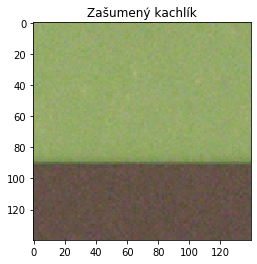

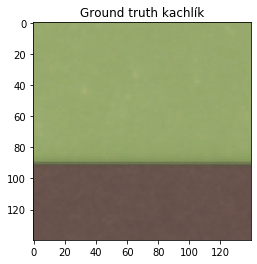

In [2]:
data = load_image_data().unbatch().skip(2000).take(1)
for img in data:
    visualize_img(img[0], 'Zašumený kachlík') 
    visualize_img(img[1], 'Ground truth kachlík')

Pri analýze rozsahu šumu budeme používať metódu SSIM určenú na vyhodnocovanie podobnosti obrázkov.

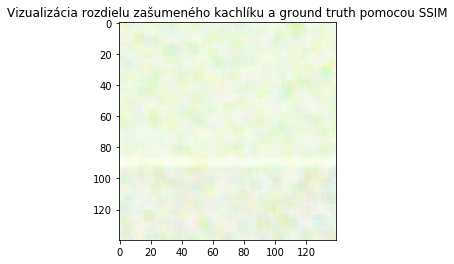

0.9248876813480317


In [3]:
data = load_image_data().unbatch().skip(2000).take(1)
for img in data:
    score, diff = calculate_ssim(img[0].numpy(), img[1].numpy())
    visualize_img(diff, 'Vizualizácia rozdielu zašumeného kachlíku a ground truth pomocou SSIM')

    print(score)
    

Pri odstraňovaní šumu s natrénovanou sieťou sa obrázok rozdelí, pre každý kachlík sa vytvorí predikcia a následne sa tieto predikcie spoja naspäť do celého obrázku.

Dokumentácia
===========
Tento dokument slúži ako dokumentácia konvolučnej neurónovej siete zamerannej filtrovanie zašumeného obrazu.

V súbore `models.py` je model navrhnutej neurónovej siete.

V súbore `utils.py` sú pomocné funkcie na predspracovanie a načítanie dát.

V súbore `nsiete.py` je hlavný skript, ktorý načíta dáta a spustí trénovanie.

## Návrh architektúry
Baseline riešenie je implementáciou DnCNN architektúry navrhnutej v [tejto práci](https://arxiv.org/pdf/1608.03981.pdf)

![Diagram architektúry v pôvodnej práci](https://www.researchgate.net/profile/Yunjin_Chen/publication/306187437/figure/fig4/AS:667093628379148@1536058923422/The-architecture-of-the-proposed-DnCNN-network.png)
Diagram architektúry v pôvodnej práci.

Táto architektúra má na výstupe obrázok pozostávajúci len zo šumu, preto sme na koniec modelu pridali vrstvu, ktorá odpočíta šum od pôvodného obrázku.

Neurónová sieť pozostáva zo série konvolučných vrstiev používajúcich konvolučné jadro o veľkosti 3x3 posúvajúcich sa po jednom pixeli. Aktivačná funkcia je ReLU. Počet vrstiev nie je pevne daný, ale aj jeho určenie je súčasťou experimentu (minimálny počet je dve). Všetky konvolučné vrstvy okrem záverečnej obsahujú 64 filtrov, záverečná iba 3. Súčasťou siete sú aj vrsty ZeroPadding2D a Cropping2D na opačných koncoch architektúry, ktoré pridávajú vstupným obrázkom padding za účelom odstránenia artefaktov po krajoch výsledného obrázku. Druhá až predposledná vrstva využívajú aj _batch normalization_.

V rámci objektívneho vyhodnocovania výsledkov našej neurónovej siete pri rôznych nastaveniach hyperparametrov využijeme absolútny rozdiel pixelových hodnôt bezchybného obrazu na vstupe a výsledného obrazu po predikcii našou neurónovou sieťou. Vizualizácia tohto rozdielu nám pomôže odhaliť, ktoré prvky či javy obrazu robia sieti problémy a s ktorými sa naopak dokáže vysporiadať.

# Opis trénovania
Na trénovanie jednotlivých modelov sme použili technológiu CUDA® v10.0 bežiacu na grafickej jednotke Nvidia GTX 980.

## Validácia
Naša neurónová sieť sa pri trénovaní validuje na podmnožine predspracovaných (rozdelených na kachlíky) obrázkov, ktorá bola pred trénovaním oddelená od ostatných. Model používa metriku PSNR.

# Výsledky experimentov
Sieť sme podrobili mnohým experimentom s rôznym nastavením hyperparametrov. Okrem nich sme experimentovali aj s hĺbkou siete a veľkosťou kachlíkov (viď dokumentácia).

Prehľad trénovania našej siete:
![Presnosť](/images/epoch_accuracy.png)  
![Stratová funkcia](/images/epoch_loss.png)  

Najzaujímavejšie modely podrobne uvádzame:

In [4]:
#nacitanie obrazkov
image = mpimg.imread('datasets/SIDD_Small_sRGB_Only/SIDD_Small_sRGB_Only/Data/0118_006_N6_00100_00025_3200_L/NOISY_SRGB_010.PNG')
gt_image = mpimg.imread('datasets/SIDD_Small_sRGB_Only/SIDD_Small_sRGB_Only/Data/0118_006_N6_00100_00025_3200_L/GT_SRGB_010.PNG')

image_patches_overlap = image_to_patches(image, overlap=True)
gt_image_patches_overlap = image_to_patches(gt_image, overlap=True)

joined_image_overlap = patches_to_image(image_patches_overlap, image.shape[0], image.shape[1], overlap=True)

Height is 3120
Width is 4208
Vertical number of patches is: 23
Horizontal number of patches is: 31
(45, 61, 140, 140, 3)
(2745, 140, 140, 3)
(2745, 70, 70, 3)
(1, 3150, 4270, 3)


### Hĺbka siete: 17; Počet epoch: 5; Počet krokov: 1000; Počet validačných krokov: 50; Veľkosť kachlíku: 140px

Výsledky neurónovej siete s uvedenými parametrami:

In [5]:
loaded = keras.models.load_model('models/model_made_on_2019-12-01_at_21-50-20', compile=False)
loaded.compile(optimizer=keras.optimizers.Adam(), loss=dcnn_loss, metrics=[psnr])

reconstructed_patches_overlap = use_predict_on_patches(image_patches_overlap, loaded)
reconstructed_image_overlap = patches_to_image(reconstructed_patches_overlap, image.shape[0], image.shape[1], overlap=True)

Prediction done (1 of 2745) (140, 140, 3)
Prediction done (2 of 2745) (140, 140, 3)
Prediction done (3 of 2745) (140, 140, 3)
Prediction done (4 of 2745) (140, 140, 3)
Prediction done (5 of 2745) (140, 140, 3)
Prediction done (6 of 2745) (140, 140, 3)
Prediction done (7 of 2745) (140, 140, 3)
Prediction done (8 of 2745) (140, 140, 3)
Prediction done (9 of 2745) (140, 140, 3)
Prediction done (10 of 2745) (140, 140, 3)
Prediction done (11 of 2745) (140, 140, 3)
Prediction done (12 of 2745) (140, 140, 3)
Prediction done (13 of 2745) (140, 140, 3)
Prediction done (14 of 2745) (140, 140, 3)
Prediction done (15 of 2745) (140, 140, 3)
Prediction done (16 of 2745) (140, 140, 3)
Prediction done (17 of 2745) (140, 140, 3)
Prediction done (18 of 2745) (140, 140, 3)
Prediction done (19 of 2745) (140, 140, 3)
Prediction done (20 of 2745) (140, 140, 3)
Prediction done (21 of 2745) (140, 140, 3)
Prediction done (22 of 2745) (140, 140, 3)
Prediction done (23 of 2745) (140, 140, 3)
Prediction done (24 

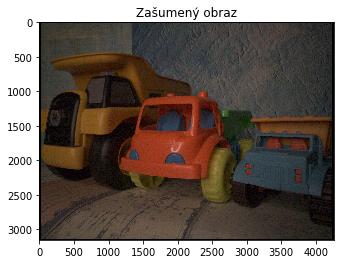

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


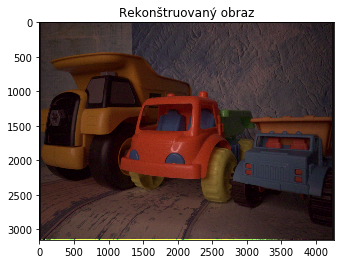

In [6]:
visualize_img(joined_image_overlap[0], 'Zašumený obraz')
visualize_img(reconstructed_image_overlap[0], 'Rekonštruovaný obraz')

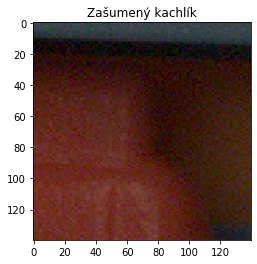

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


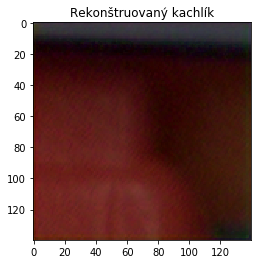

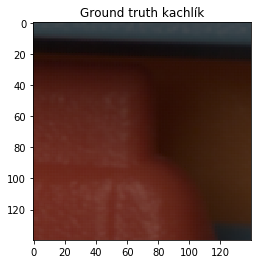

In [7]:
visualize_img(image_patches_overlap[1513], 'Zašumený kachlík')
visualize_img(reconstructed_patches_overlap[1513][0], 'Rekonštruovaný kachlík')
visualize_img(gt_image_patches_overlap[1513], 'Ground truth kachlík')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


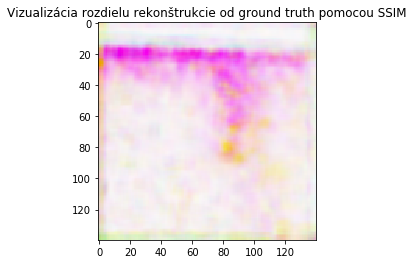

0.9028237350449291


In [8]:
score, diff = calculate_ssim(reconstructed_patches_overlap[1513][0], gt_image_patches_overlap[1513].numpy())
visualize_img(diff, 'Vizualizácia rozdielu rekonštrukcie od ground truth pomocou SSIM')

print(score)

### Hĺbka siete: 17; Počet epoch: 5; Počet krokov: 2000; Počet validačných krokov: 10; Veľkosť kachlíku: 140px

Výsledky neurónovej siete s uvedenými parametrami:

In [9]:
loaded = keras.models.load_model('models/model_made_on_2019-11-17_at_21-32-59', compile=False)
loaded.compile(optimizer=keras.optimizers.Adam(), loss=dcnn_loss, metrics=['accuracy'])

reconstructed_patches_overlap = use_predict_on_patches(image_patches_overlap, loaded)
reconstructed_image_overlap = patches_to_image(reconstructed_patches_overlap, image.shape[0], image.shape[1], overlap=True)

Prediction done (1 of 2745) (140, 140, 3)
Prediction done (2 of 2745) (140, 140, 3)
Prediction done (3 of 2745) (140, 140, 3)
Prediction done (4 of 2745) (140, 140, 3)
Prediction done (5 of 2745) (140, 140, 3)
Prediction done (6 of 2745) (140, 140, 3)
Prediction done (7 of 2745) (140, 140, 3)
Prediction done (8 of 2745) (140, 140, 3)
Prediction done (9 of 2745) (140, 140, 3)
Prediction done (10 of 2745) (140, 140, 3)
Prediction done (11 of 2745) (140, 140, 3)
Prediction done (12 of 2745) (140, 140, 3)
Prediction done (13 of 2745) (140, 140, 3)
Prediction done (14 of 2745) (140, 140, 3)
Prediction done (15 of 2745) (140, 140, 3)
Prediction done (16 of 2745) (140, 140, 3)
Prediction done (17 of 2745) (140, 140, 3)
Prediction done (18 of 2745) (140, 140, 3)
Prediction done (19 of 2745) (140, 140, 3)
Prediction done (20 of 2745) (140, 140, 3)
Prediction done (21 of 2745) (140, 140, 3)
Prediction done (22 of 2745) (140, 140, 3)
Prediction done (23 of 2745) (140, 140, 3)
Prediction done (24 

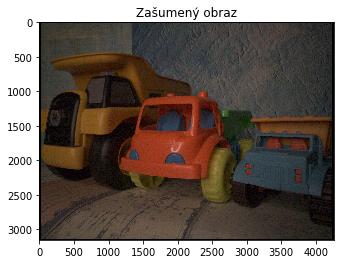

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


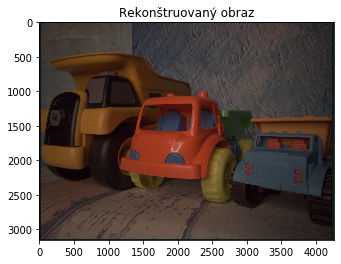

In [10]:
visualize_img(joined_image_overlap[0], 'Zašumený obraz')
visualize_img(reconstructed_image_overlap[0], 'Rekonštruovaný obraz')

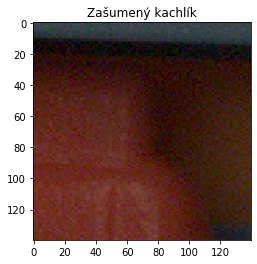

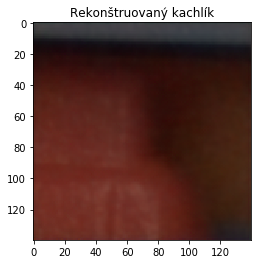

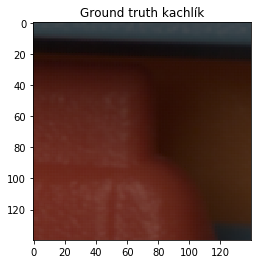

In [11]:
visualize_img(image_patches_overlap[1513], 'Zašumený kachlík')
visualize_img(reconstructed_patches_overlap[1513][0], 'Rekonštruovaný kachlík')
visualize_img(gt_image_patches_overlap[1513], 'Ground truth kachlík')

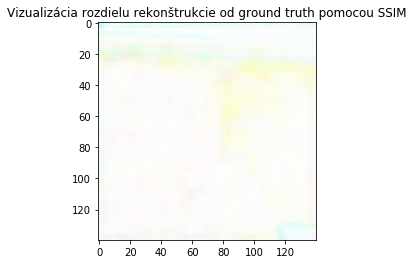

0.9784880427059767


In [12]:
score, diff = calculate_ssim(reconstructed_patches_overlap[1513][0], gt_image_patches_overlap[1513].numpy())
visualize_img(diff, 'Vizualizácia rozdielu rekonštrukcie od ground truth pomocou SSIM')

print(score)

## Zhodnotenie
Cieľom tohto projektu bolo preskúmať možnosť využitia konvolučných neurónových sietí. Experimentovaním a analýzou sme
preverili možnosť využitia CNN na úlohu odstraňovania prirodzeného šumu smartfónových fotografií.
Najväčším prekvapením pre nás bola skutočnosť, že na dosiahnutie uspokojivých výsledkov postačil dataset 200 fotografií.
Tréning bol tiež prekvapivo časovo nenáročný – treba však podotknúť, že trénovanie niekoľkonásobne urýchlila
 použitá technológia CUDA®. Odhalenými nedostatkami nášho modelu sú nepresnosti predikcie, konkrétne
  mierne rozmazanie ostrých hrán a zmena farebného spektra. Ide o štandardné chyby konvolučných sietí, ktoré možno
  minimalizovať ladením trénovania a rozšírením datasetu. Ďalšou prácou na projekte by mohlo byť testovanie rôznych datasetov
  s rozličným typom šumu.
 Za zváženie stojí aj úvaha natrénovať univerzálny model, ktorý by sa dokázal vysporiadať s rôznymi
 typmi šumu. 